In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from particle import Particle, InvalidParticle, ParticleNotFound
from particle_utils import get_charge_from_pdgc, get_name_from_pdgc

# Initial FASERvSi studies

Detector setup:
132 layers of Tungsten and 'SCT' (sensitive vacuum)
Tungsten layers are 0.9 mm thick
Gap between Tungsten sheets is 7.08 mm
1000 events generated - mix of $\nu_e$, $\nu_\mu$ and $\nu_\tau$


In [2]:
data = uproot.open("/home/bewilson/FASERvSi_G4/GeantOutput/FASERvSi-ccLepFlagged.1000.HITS.root")
hits = [data[treename] for treename in data.keys() if "Hits" in treename]
truth = data["truth"]

In [3]:
output_dir = "eventPlots/FASERvSi.1000.HITS/"
os.makedirs(output_dir, exist_ok=True)

In [4]:
pdgc = hits[-1].arrays("pdgc", library="np")["pdgc"]

pdgc = set(pdgc)

for p in pdgc:
    print(f"pdgc = {p:<13}    name = {get_name_from_pdgc(p):<13}    charge = {get_charge_from_pdgc(p)}")

pdgc = 130.0            name = K(L)0            charge = K(L)0
pdgc = -3322.0          name = anti-Xi~0        charge = anti-Xi~0
pdgc = 11.0             name = e-               charge = e-
pdgc = 12.0             name = nu(e)            charge = nu(e)
pdgc = 13.0             name = mu-              charge = mu-
pdgc = 14.0             name = nu(mu)           charge = nu(mu)
pdgc = -3312.0          name = Xi~+             charge = Xi~+
pdgc = 16.0             name = nu(tau)          charge = nu(tau)
pdgc = 22.0             name = gamma            charge = gamma
pdgc = 3222.0           name = Sigma+           charge = Sigma+
pdgc = 4122.0           name = Lambda(c)+       charge = Lambda(c)+
pdgc = 2212.0           name = p                charge = p
pdgc = 1000010020.0     name = D2               charge = D2
pdgc = 3112.0           name = Sigma-           charge = Sigma-
pdgc = -211.0           name = pi-              charge = pi-
pdgc = 1000010030.0     name = T3               charge =

In [5]:
def scatter_on_ax(ax, event_data, x_var, y_var, label, color,  alpha=1, marker_size=1):
    
    if len(event_data[x_var]) == 0:
        return None
    
    return ax.scatter(event_data[x_var], event_data[y_var], color=color, marker=",", label=label, alpha=alpha, s=marker_size)

In [6]:
def set_offsets_on_scatter(scatter, event_data, x_var, y_var):
    
    if len(event_data[x_var]) == 0:
        return None
    
    return scatter.set_offsets(np.c_[event_data[x_var], event_data[y_var]])

In [7]:
event_numbers = truth.arrays("fEvent", library="np")["fEvent"]

In [8]:
neutrino_pdgc_to_label_dict = {12: r"$\nu_e$",
                               -12: r"$\bar{\nu}_e$",
                               14: r"$\nu_\mu$",
                               -14: r"$\bar{\nu}_\mu$",
                               16: r"$\nu_\tau$",
                               -16: r"$\bar{\nu}_\tau$",
                                }

In [9]:

for i in tqdm(range(0, 100)):
    
    fig, ax = plt.subplots(ncols=2  )

    truth_info = truth.arrays(truth.keys(), library="ak", cut=f"fEvent == {event_numbers[i]}")
    
    neutrino_pdgc = truth_info['nu_pdgc'][0]
    neutrino_energy = truth_info['nu_E'][0]
    target_pdgc = truth_info['target_pdgc'][0]
    event_number = truth_info['fEvent'][0]
    vx = truth_info['vertex_x']
    vy = truth_info['vertex_y']
    vz = truth_info['vertex_z']
    is_cc = bool(truth_info['isCC'][0])
    is_cc_label = "CC" if is_cc else "NC"
    
    ax[0].scatter(vz, vy, color="black", marker='x', s=1.5, label="primary vertex", zorder=100)
    ax[1].scatter(vx, vy, color="black", marker='x', s=1.5, label="primary vertex", zorder=100)
    
    for s, station in enumerate(hits):
        
        kinematics = station.arrays(station.keys(), library="ak", cut=f"(fEvent == {event_numbers[i]}) & (z > 0)")
        
        # print(kinematics)
        
        marker_size = 1
        alpha = 1
        
        electrons = kinematics[np.where(np.abs(kinematics['pdgc']) == 11)]
        muons = kinematics[np.where(np.abs(kinematics['pdgc']) == 13)]
        taus = kinematics[np.where(np.abs(kinematics['pdgc']) == 15)]
        
        gluons = kinematics[np.where(np.abs(kinematics['pdgc']) == 21)]
        photons = kinematics[np.where(np.abs(kinematics['pdgc']) == 22)]
        charged_hadrons = kinematics[np.where(np.abs(kinematics['pdgc']) > 37)]
        neutral_hadrons = kinematics[np.where(np.abs(kinematics['pdgc']) > 37)]
        charged_hadrons = kinematics[np.where(get_charge_from_pdgc(kinematics['pdgc']) != 0)]
        neutral_hadrons = kinematics[np.where(get_charge_from_pdgc(kinematics['pdgc']) == 0)]
        
        # scatter_on_ax(ax[0], neutral_hadrons, "z", "y", "neutral hadrons", 'grey', alpha=0.5, marker_size=marker_size)
        scatter_on_ax(ax[0], charged_hadrons, "z", "y", "charged hadrons", 'forestgreen', alpha=alpha, marker_size=marker_size)
        # scatter_on_ax(ax[0], photons, "z", "y", r"$\gamma$", 'yellow', alpha=0.5, marker_size=marker_size)
        # scatter_on_ax(ax[0], gluons, "z", "y", r"$g$", 'orange', alpha=0.5, marker_size=marker_size)
        scatter_on_ax(ax[0], electrons, "z", "y", r"$e^\pm$", 'lightblue', alpha=alpha, marker_size=marker_size)
        scatter_on_ax(ax[0], muons, "z", "y", r"$\mu^\pm$", 'tomato', alpha=alpha, marker_size=marker_size)
        scatter_on_ax(ax[0], taus, "z", "y", r"$\tau^\pm$", 'purple', alpha=alpha, marker_size=marker_size)
        
        # scatter_on_ax(ax[0], neutral_hadrons, "x", "y", "neutral hadrons", 'grey', alpha=0.5, marker_size=marker_size)
        scatter_on_ax(ax[1], charged_hadrons, "x", "y", "charged hadrons", 'forestgreen', alpha=alpha, marker_size=marker_size)
        # scatter_on_ax(ax[0], photons, "x", "y", r"$\gamma$", 'yellow', alpha=0.5, marker_size=marker_size)
        # scatter_on_ax(ax[0], gluons, "x", "y", r"$g$", 'orange', alpha=0.5, marker_size=marker_size)
        scatter_on_ax(ax[1], electrons, "x", "y", r"$e^\pm$", 'lightblue', alpha=alpha, marker_size=marker_size)
        scatter_on_ax(ax[1], muons, "x", "y", r"$\mu^\pm$", 'tomato', alpha=alpha, marker_size=marker_size)
        scatter_on_ax(ax[1], taus, "x", "y", r"$\tau^\pm$", 'purple', alpha=alpha, marker_size=marker_size)
        
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    
    ax[0].set_title(f"{is_cc_label} {neutrino_pdgc_to_label_dict[neutrino_pdgc]} + {get_name_from_pdgc(target_pdgc)}", loc="left")
    ax[0].set_title(f"Neutrino energy = {neutrino_energy:.2f} GeV", loc="right")
    ax[1].set_title(f"Event Number: {event_number}", loc="right")
    
    ax[0].legend(by_label.values(), by_label.keys())# , ncols=2) #, loc='center right', bbox_to_anchor=(1.55, 0.75))
    ax[1].legend(by_label.values(), by_label.keys())# , ncols=2) #, loc='center right', bbox_to_anchor=(1.55, 0.75)) 
    
    ax[0].set_xlabel("z position (mm)")
    ax[0].set_ylabel("y position (mm)")
    ax[0].set_xlim((550, 1600))
    ax[0].set_ylim((-150, 150))
    
    ax[1].set_xlabel("x position (mm)")
    ax[1].set_ylabel("y position (mm)")
    ax[1].set_xlim((-125, 125))
    ax[1].set_ylim((-150, 150))
    
    plt.savefig(f"{output_dir}/event_{i}_particle-dist-x-y-z-y.png", dpi=300, bbox_inches='tight')
    # plt.show()
    plt.close()
    # break
        

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [08:48<00:00,  5.28s/it]


In [10]:
true_tau_events = truth.arrays(truth.keys(), library='ak', cut="(nu_pdgc == 16) | (nu_pdgc == -16)")    
print(true_tau_events['fEvent'])

[20814235, 92600902, 70152241, 41393323, 49152262]


  0%|          | 0/5 [00:00<?, ?it/s]

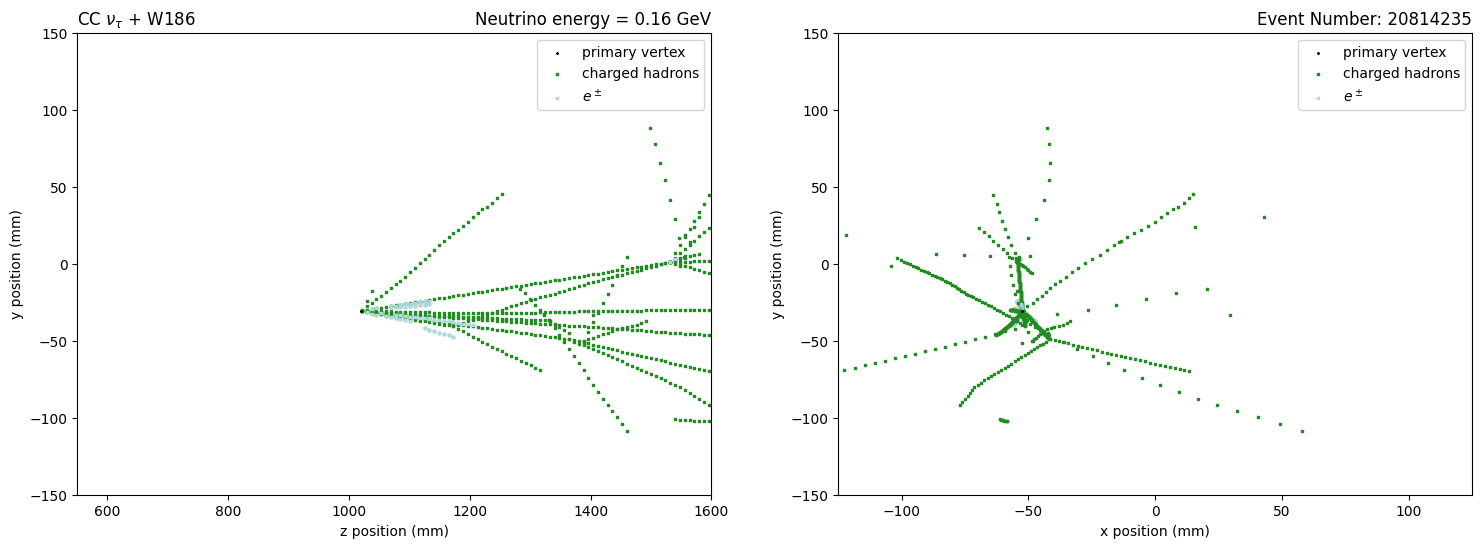

 20%|██        | 1/5 [00:05<00:21,  5.27s/it]

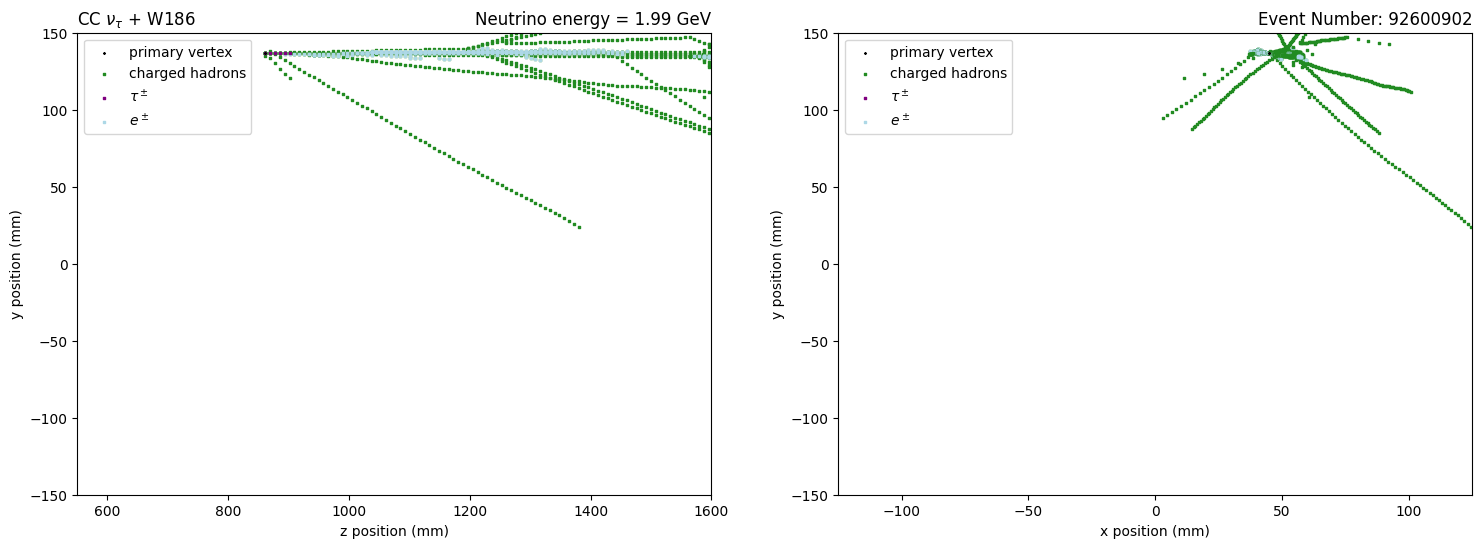

 40%|████      | 2/5 [00:12<00:18,  6.14s/it]

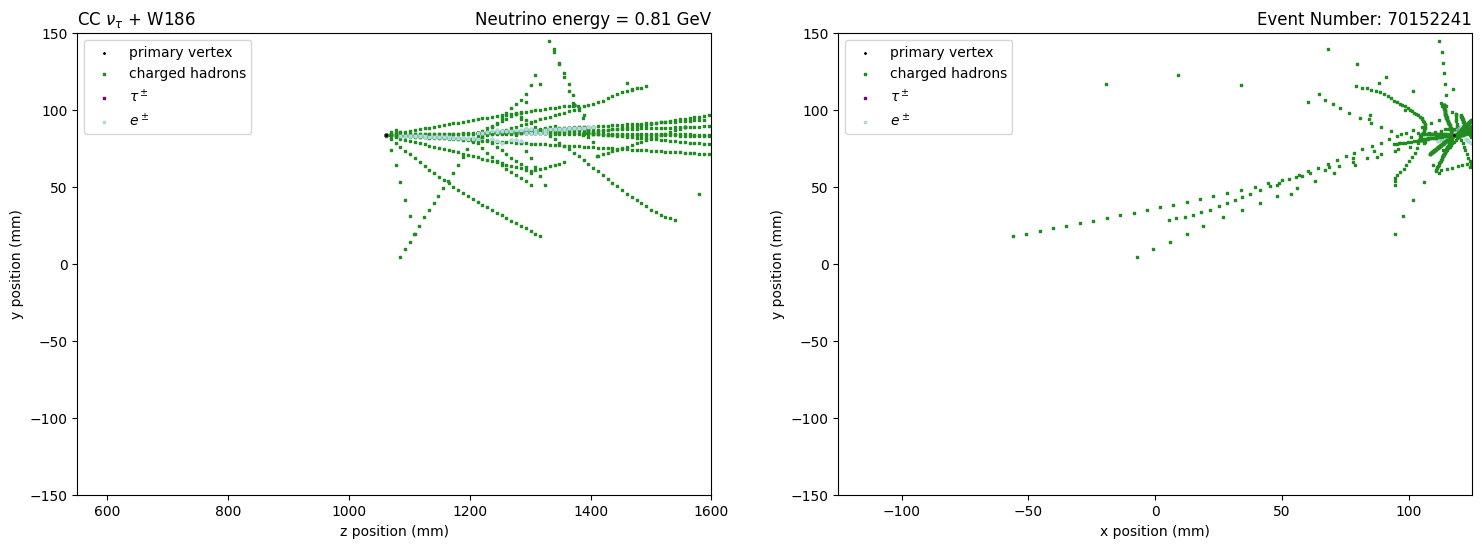

 60%|██████    | 3/5 [00:17<00:12,  6.02s/it]

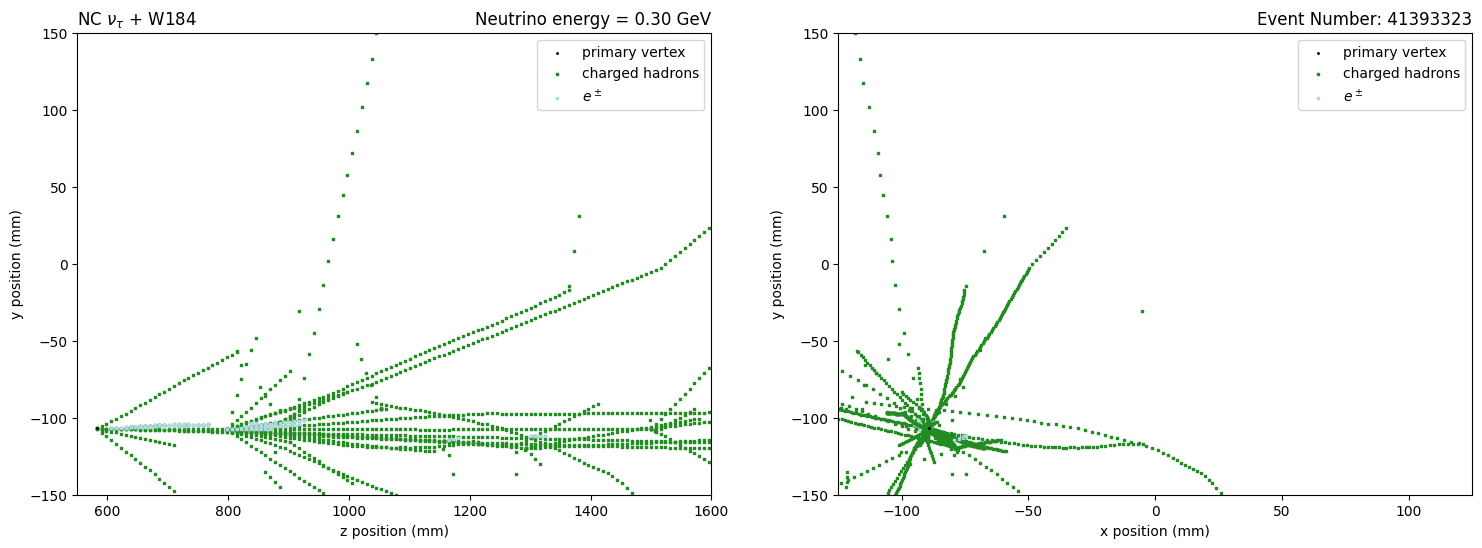

 80%|████████  | 4/5 [00:23<00:05,  5.90s/it]

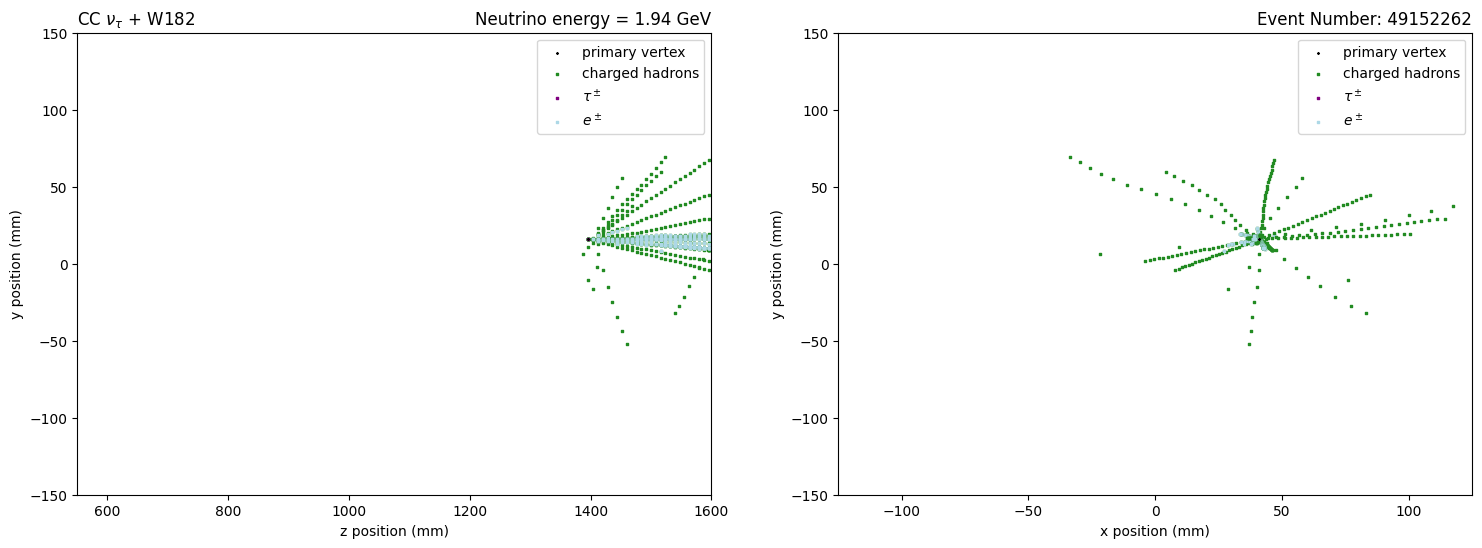

100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


In [11]:
for event_number in tqdm(true_tau_events['fEvent']):
    
    fig, ax = plt.subplots(ncols=2, figsize=(18, 6))

    truth_info = truth.arrays(truth.keys(), library="ak", cut=f"fEvent == {event_number}")
    
    neutrino_pdgc = truth_info['nu_pdgc'][0]
    neutrino_energy = truth_info['nu_E'][0]
    target_pdgc = truth_info['target_pdgc'][0]
    event_number = truth_info['fEvent'][0]
    vx = truth_info['vertex_x']
    vy = truth_info['vertex_y']
    vz = truth_info['vertex_z']
    is_cc = bool(truth_info['isCC'][0])
    is_cc_label = "CC" if is_cc else "NC"
    
    ax[0].scatter(vz, vy, color="black", marker='x', s=1.5, label="primary vertex", zorder=100)
    ax[1].scatter(vx, vy, color="black", marker='x', s=1.5, label="primary vertex", zorder=100)
    
    for s, station in enumerate(hits):
        
        kinematics = station.arrays(station.keys(), library="ak", cut=f"(fEvent == {event_number}) & (z > 0)")
        
        # print(kinematics)
        
        marker_size = 1
        alpha = 1
        
        electrons = kinematics[np.where(np.abs(kinematics['pdgc']) == 11)]
        muons = kinematics[np.where(np.abs(kinematics['pdgc']) == 13)]
        taus = kinematics[np.where(np.abs(kinematics['pdgc']) == 15)]
        
        gluons = kinematics[np.where(np.abs(kinematics['pdgc']) == 21)]
        photons = kinematics[np.where(np.abs(kinematics['pdgc']) == 22)]
        charged_hadrons = kinematics[np.where(np.abs(kinematics['pdgc']) > 37)]
        neutral_hadrons = kinematics[np.where(np.abs(kinematics['pdgc']) > 37)]
        charged_hadrons = kinematics[np.where(get_charge_from_pdgc(kinematics['pdgc']) != 0)]
        neutral_hadrons = kinematics[np.where(get_charge_from_pdgc(kinematics['pdgc']) == 0)]
        
        # scatter_on_ax(ax[0], neutral_hadrons, "z", "y", "neutral hadrons", 'grey', alpha=0.5, marker_size=marker_size)
        scatter_on_ax(ax[0], charged_hadrons, "z", "y", "charged hadrons", 'forestgreen', alpha=alpha, marker_size=marker_size)
        # scatter_on_ax(ax[0], photons, "z", "y", r"$\gamma$", 'yellow', alpha=0.5, marker_size=marker_size)
        # scatter_on_ax(ax[0], gluons, "z", "y", r"$g$", 'orange', alpha=0.5, marker_size=marker_size)
        scatter_on_ax(ax[0], electrons, "z", "y", r"$e^\pm$", 'lightblue', alpha=alpha, marker_size=marker_size)
        scatter_on_ax(ax[0], muons, "z", "y", r"$\mu^\pm$", 'tomato', alpha=alpha, marker_size=marker_size)
        scatter_on_ax(ax[0], taus, "z", "y", r"$\tau^\pm$", 'purple', alpha=alpha, marker_size=marker_size)
        
        # scatter_on_ax(ax[0], neutral_hadrons, "x", "y", "neutral hadrons", 'grey', alpha=0.5, marker_size=marker_size)
        scatter_on_ax(ax[1], charged_hadrons, "x", "y", "charged hadrons", 'forestgreen', alpha=alpha, marker_size=marker_size)
        # scatter_on_ax(ax[0], photons, "x", "y", r"$\gamma$", 'yellow', alpha=0.5, marker_size=marker_size)
        # scatter_on_ax(ax[0], gluons, "x", "y", r"$g$", 'orange', alpha=0.5, marker_size=marker_size)
        scatter_on_ax(ax[1], electrons, "x", "y", r"$e^\pm$", 'lightblue', alpha=alpha, marker_size=marker_size)
        scatter_on_ax(ax[1], muons, "x", "y", r"$\mu^\pm$", 'tomato', alpha=alpha, marker_size=marker_size)
        scatter_on_ax(ax[1], taus, "x", "y", r"$\tau^\pm$", 'purple', alpha=alpha, marker_size=marker_size)
        
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    
    ax[0].set_title(f"{is_cc_label} {neutrino_pdgc_to_label_dict[neutrino_pdgc]} + {get_name_from_pdgc(target_pdgc)}", loc="left")
    ax[0].set_title(f"Neutrino energy = {neutrino_energy/1e3:.2f} GeV", loc="right")
    ax[1].set_title(f"Event Number: {event_number}", loc="right")
    
    ax[0].legend(by_label.values(), by_label.keys())# , ncols=2) #, loc='center right', bbox_to_anchor=(1.55, 0.75))
    ax[1].legend(by_label.values(), by_label.keys())# , ncols=2) #, loc='center right', bbox_to_anchor=(1.55, 0.75)) 
    
    ax[0].set_xlabel("z position (mm)")
    ax[0].set_ylabel("y position (mm)")
    ax[0].set_xlim((550, 1600))
    ax[0].set_ylim((-150, 150))
    
    ax[1].set_xlabel("x position (mm)")
    ax[1].set_ylabel("y position (mm)")
    ax[1].set_xlim((-125, 125))
    ax[1].set_ylim((-150, 150))
    
    plt.savefig(f"{output_dir}/event_{i}_particle-dist-x-y-z-y.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    # break
        

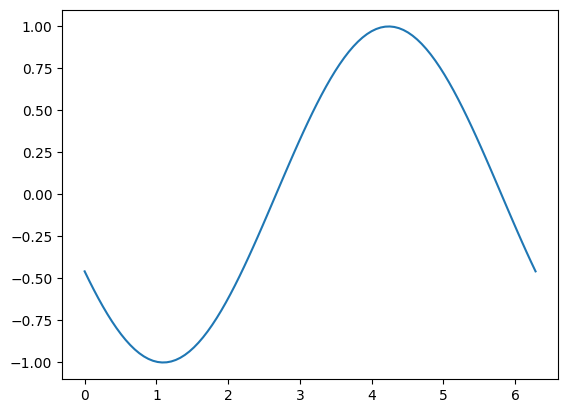

In [12]:
# %matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import matplotlib as mpl
# Set the ffmpeg path
plt.rcParams["animation.html"] = "jshtml"


# Create a figure and axis
fig, ax = plt.subplots()
x = np.linspace(0, 2 * np.pi, 100)
line, = ax.plot(x, np.sin(x))

# Update function for animation
def update(frame):
    line.set_ydata(np.sin(x + frame / 10.0))  # Update the data.
    return line,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=100, blit=True)
from IPython.display import HTML
HTML(ani.to_jshtml())
# plt.show()

# Save the animation (optional)
# ani.save('animation.mp4', writer='ffmpeg') // NOTE: Saving animation blocks inline animation from being rendered




In [13]:
def get_station_charged_hits(station, event_number):
    kinematics = station.arrays(station.keys(), library="ak", cut=f"(fEvent == {event_number}) & (z > 0)")
    electrons = kinematics[np.where(np.abs(kinematics['pdgc']) == 11)]
    muons = kinematics[np.where(np.abs(kinematics['pdgc']) == 13)]
    taus = kinematics[np.where(np.abs(kinematics['pdgc']) == 15)]
    
    charged_hadrons = kinematics[np.where(np.abs(kinematics['pdgc']) > 37)]
    charged_hadrons = kinematics[np.where(get_charge_from_pdgc(kinematics['pdgc']) != 0)]
    
    return electrons, muons, taus, charged_hadrons
    

 99%|█████████▉| 131/132 [00:39<00:00,  2.69it/s]

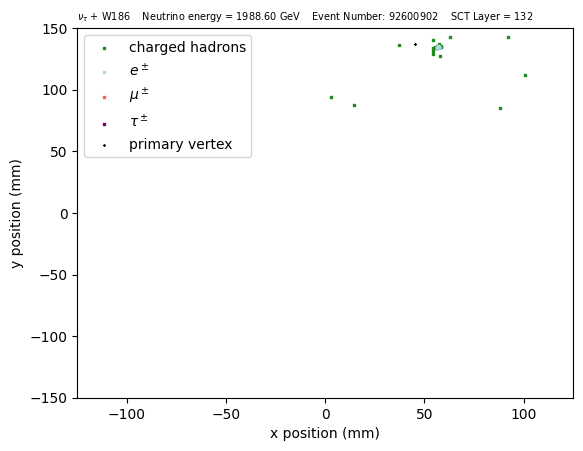

In [14]:
# %matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"

data = uproot.open("/home/bewilson/FASERvSi_G4/GeantOutput/FASERvSi.1000.HITS.root")
hits = [data[treename] for treename in data.keys() if "Hits" in treename]
truth = data["truth"]

def make_hit_animation(hits, truth, event_number):
    
    # Create a figure and axis
    fig, ax = plt.subplots()
    marker_size = 1
    alpha = 1
    os.makedirs(f"{event_number}_frames", exist_ok=True)
    
    # Get truth data
    truth_info = truth.arrays(truth.keys(), library='ak', cut=f"fEvent == {event_number}")
    neutrino_pdgc = truth_info['nu_pdgc'][0]
    neutrino_energy = truth_info['nu_E'][0]
    target_pdgc = truth_info['target_pdgc'][0]
    event_number = truth_info['fEvent'][0]
    vx = truth_info['vertex_x']
    vy = truth_info['vertex_y']
    vz = truth_info['vertex_z']
    
    # Setup plot
    charged_had_scatter  = ax.scatter([], [], label="charged hadrons", color='forestgreen', alpha=alpha, s=marker_size, marker=',')
    electron_scatter     = ax.scatter([], [], label=r"$e^\pm$", color='lightblue', alpha=alpha, s=marker_size, marker=',')
    muon_scatter         = ax.scatter([], [], label=r"$\mu^\pm$", color='tomato', alpha=alpha, s=marker_size, marker=',')
    tau_scatter          = ax.scatter([], [], label=r"$\tau^\pm$", color='purple', alpha=alpha, s=marker_size, marker=',')
    vtx_scatter          = ax.scatter([], [], label="primary vertex", color='black', alpha=alpha, s=marker_size, marker='x')
    ax.set_xlabel("x position (mm)")
    ax.set_ylabel("y position (mm)")
    ax.set_xlim((-125, 125))
    ax.set_ylim((-150, 150))
    ax.set_title(f"{neutrino_pdgc_to_label_dict[neutrino_pdgc]} + {get_name_from_pdgc(target_pdgc)}    Neutrino energy = {neutrino_energy/1e3:.2f} GeV    Event Number: {event_number}    SCT Layer = {1}", loc="left", fontsize=7)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())# , ncols=2) #, loc='center right', bbox_to_anchor=(1.55, 0.75))
    
    # Init function
    def init():
        charged_had_scatter.set_offsets(np.empty((0, 2)))
        electron_scatter.set_offsets(np.empty((0, 2)))   
        muon_scatter.set_offsets(np.empty((0, 2)))       
        tau_scatter.set_offsets(np.empty((0, 2)))        
        vtx_scatter.set_offsets(np.empty((0, 2)))        
        
        return charged_had_scatter, electron_scatter, muon_scatter, tau_scatter, vtx_scatter     
    
    # Update function for animation
    def update(frame, hits, truth_info, event_number):
        kinematics = hits[frame].arrays(hits[frame].keys(), library="ak", cut=f"(fEvent == {event_number}) & (z > 0)")
        
        # print(frame, kinematics) #hits[frame].arrays(hits[frame].keys() , library="ak"))
        
        neutrino_pdgc = truth_info['nu_pdgc'][0]
        neutrino_energy = truth_info['nu_E'][0]
        target_pdgc = truth_info['target_pdgc'][0]
        event_number = truth_info['fEvent'][0]
        vx = truth_info['vertex_x']
        vy = truth_info['vertex_y']
        vz = truth_info['vertex_z']
        
        electrons = kinematics[np.where(np.abs(kinematics['pdgc']) == 11)]
        muons = kinematics[np.where(np.abs(kinematics['pdgc']) == 13)]
        taus = kinematics[np.where(np.abs(kinematics['pdgc']) == 15)]
        
        charged_hadrons = kinematics[np.where(np.abs(kinematics['pdgc']) > 37)]
        charged_hadrons = kinematics[np.where(get_charge_from_pdgc(kinematics['pdgc']) != 0)]
        
        charged_had_scatter.set_offsets(np.c_[charged_hadrons["x"], charged_hadrons["y"]])
        electron_scatter.set_offsets(np.c_[electrons["x"], electrons['y']])
        muon_scatter.set_offsets(np.c_[muons["x"], muons['y']])
        tau_scatter.set_offsets(np.c_[taus["x"], taus['y']])
        
        if len(electrons) != 0 or len(muons) != 0 or len(taus) != 0 or len(charged_hadrons) != 0:
            vtx_scatter.set_offsets(np.c_[vx, vy])

        fig.savefig(f"{event_number}_frames/{event_number}-hit-layer-{frame}.png", dpi=300)
        ax.set_title(f"{neutrino_pdgc_to_label_dict[neutrino_pdgc]} + {get_name_from_pdgc(target_pdgc)}    Neutrino energy = {neutrino_energy/1e3:.2f} GeV    Event Number: {event_number}    SCT Layer = {frame+1}", loc="left", fontsize=7)
        return charged_had_scatter, electron_scatter, muon_scatter, tau_scatter, vtx_scatter

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=tqdm(range(len(hits))), blit=True, init_func=init, fargs=(hits, truth_info, event_number))
    from IPython.display import HTML
    HTML(ani.to_jshtml())
    # plt.show()

    # Save the animation (optional)
    ani.save(f'{event_number}.mp4', writer='ffmpeg') # NOTE: Saving animation blocks inline animation from being rendered

make_hit_animation(hits, truth, 92600902)
